In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\Soham.Dutta\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
con=sqlite3.connect('C:/Users/Soham.Dutta/AAIC/Amazon reviews/database.sqlite')
filtered_data = pd.read_sql_query(" SELECT * FROM  Reviews where Score != 3 ", con) 
# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.

def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
print(filtered_data.head(3))


"""
filtered_data.head()
filtered_data['Score'] = np.where(filtered_data['Score']<3, 0, 1)
filtered_data['Score'].value_counts()
filtered_data.head()
"""



Number of data points in our data (525814, 10)
   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      1  1303862400   
1                     0                       0      0  1346976000   
2                     1                       1      1  1219017600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...  


"\nfiltered_data.head()\nfiltered_data['Score'] = np.where(filtered_data['Score']<3, 0, 1)\nfiltered_data['Score'].value_counts()\nfiltered_data.head()\n"

In [3]:
 with open('filtered_data.pkl', 'wb') as f:
        pickle.dump(filtered_data, f)

In [4]:
#taking 1000 points each of negative and postive reviews
filtered_data["Score"].value_counts()
filtered_data_0=filtered_data.loc[filtered_data["Score"]==0]
filtered_data_1=filtered_data.loc[filtered_data["Score"]==1]
filtered_data_0_1000=filtered_data_0.iloc[0:1000,:]

filtered_data_1_1000=filtered_data_1.iloc[0:1000,:]

filtered_data_f=pd.concat([filtered_data_0_1000,filtered_data_1_1000],axis=0,ignore_index=True)
filtered_data_f.shape

(2000, 10)

In [5]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that 

ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)

ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on
It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.
The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [6]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data_f.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [7]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
1956,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...
1957,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,This was a really good idea and the final prod...
1895,1161,B000084E1U,A3DH85EYHW4AQH,Eric Hochman,1,1,1,1140739200,Cats love it!,I have nine cats and they are crazy about thes...
948,6386,B000084EK9,A1Z54EM24Y40LL,c2,0,0,0,1090972800,This stuff is bad!,I honestly have to say that I just won't buy t...
946,6376,B000084EKD,A1Z54EM24Y40LL,c2,1,1,0,1090972800,Needs improved,I haven't had a cat yet that liked this one. ...


In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [9]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(1991, 10)


1    998
0    993
Name: Score, dtype: int64

In [ ]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(final['Text'].values)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])


Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.
Hence in the Preprocessing phase we do the following in the order below:-
Begin by removing the html tags
Remove any punctuations or limited set of special characters like , or . or # etc.
Check if the word is made up of english letters and is not alpha-numeric
Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
Convert the word to lowercase
Remove Stopwords
Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)
After which we collect the words used to describe positive and negative reviews

In [10]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

7
I bought this dog food because the bag showed pictured of veggies and chunks of meat, and with a name like "Beneful" I thought I was purchasing a nutritious brand of dog food. My dogs did eat this food, but after reading the ingredients I completely regret purchasing it and feel just awful for feeding it to my dogs. The first three ingredients are Ground yellow corn, chicken by-product meal, and corn gluten meal. How disgusting is that?! The main ingredient is a corn filler. One thing my vet told me a while back that I never forgot: "When you eat corn, what comes out of the other end? The same thing happens with dogs." Basically, dogs cannot digest corn, it is just a filler and causes them to actually eat more to feel full, poop out more, and retain less nutrients. The only meat in Beneful at all is a by-product, its not even a real meat! By-products are the stuff leftover once all the actual meat is harvested. We're talking beaks, chicken feet, eyeballs, even chicken poop! I would n

In [11]:
import nltk
nltk.download('stopwords')


stop=set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english')  #initialzing the snowball stemmer
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('sleeping'))

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
{'ma', 'itself', 'yourselves', 'was', 'off', 'ourselves', 'between', 'having', 'their', 'other', 'after', 'yours', 'very', 'has', "needn't", 'it', 'some', 'which', "aren't", 'isn', 'in', 'those', 'can', 'needn', 'is', 'them', 'm', 'your', 'as', 'to', 'who', 'once', 'be', 'd', 'me', 'whom', 'until', 'above', 'nor', 'been', 'such', 'again', 'about', 'where', 'herself', 'our', 'did', 'over', 'hasn', 'were', 'does', 'own', "won't", "shouldn't", "she's", 'had', 'just', "you've", 'doing', 'further', 'what', 'an', 'myself', "wouldn't", "hadn't", 'why', 'under', 'each', 'this', 'any', 'ain', 'my', 't', 'her', 'against', 'don', 'he', 'while', 'down', 'hers', 'no', 'only', 'but', 'on', 'that', 'out', 's', 'wasn', 'not', 'haven', 'are', 'how', 'o', 'y', 'more', 'few', 'both', "hasn't", 'these', "isn't", 'or', 'wouldn', "you'd", 'if', 'hadn', 'themselves', "don't", "you're", 'and', 'below', 'throu

In [12]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
if  os.path.isfile('C:/Users/Soham.Dutta/AAIC/Amazon reviews/database.sqlite'):
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    for i, sent in enumerate(tqdm(final['Text'].values)):
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            # we have used cleanpunc(w).split(), one more split function here because consider w="abc.def", cleanpunc(w) will return "abc def"
            # if we dont use .split() function then we will be considring "abc def" as a single word, but if you use .split() function we will get "abc", "def"
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == 1: 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(final['Score'].values)[i] == 0:
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        #print("***********************************************************************")
        final_string.append(str1)

    #############---- storing the data into .sqlite file ------########################
    final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
        # store final table into an SQlLite table for future.
    conn = sqlite3.connect('C:/Users/Soham.Dutta/AAIC/Amazon reviews/database.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    
    
    with open('positive_words.pkl', 'wb') as f:
        pickle.dump(all_positive_words, f)
    with open('negitive_words.pkl', 'wb') as f:
       pickle.dump(all_negative_words, f)


100%|██████████| 1991/1991 [00:02<00:00, 885.08it/s]


In [13]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
1956,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,receiv shipment could hard wait tri product lo...
1957,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,This was a really good idea and the final prod...,realli good idea final product outstand use de...
1895,1161,B000084E1U,A3DH85EYHW4AQH,Eric Hochman,1,1,1,1140739200,Cats love it!,I have nine cats and they are crazy about thes...,nine cat crazi kibbl last thing want cat food ...
948,6386,B000084EK9,A1Z54EM24Y40LL,c2,0,0,0,1090972800,This stuff is bad!,I honestly have to say that I just won't buy t...,honest say wont buy varieti look bad smell bad...
946,6376,B000084EKD,A1Z54EM24Y40LL,c2,1,1,0,1090972800,Needs improved,I haven't had a cat yet that liked this one. ...,havent cat yet like one littl interest think s...


In [14]:
if os.path.isfile('C:/Users/Soham.Dutta/AAIC/Amazon reviews/database.sqlite'):
    conn = sqlite3.connect('C:/Users/Soham.Dutta/AAIC/Amazon reviews/database.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")

In [15]:
#BOW
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(final['CleanedText'].values)
print("the type of count vectorizer",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

with open('Bagofwords.pkl', 'wb') as f:
    pickle.dump(final_counts, f)

the type of count vectorizer <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (1991, 5884)
the number of unique words  5884


In [ ]:
with open('positive_words.pkl', 'rb') as f:
    all_positive_words = pickle.load(f)
with open('negitive_words.pkl', 'rb') as f:
    all_negative_words = pickle.load(f)
    
    
freq_dist_positive=nltk.FreqDist(all_positive_words)
freq_dist_negative=nltk.FreqDist(all_negative_words)
print("Most Common Positive Words : ",freq_dist_positive.most_common(20))
print("Most Common Negative Words : ",freq_dist_negative.most_common(20))

Monograms and BI-Grams


In [ ]:
#Mono-gram and Bi-Gram

count_vect = CountVectorizer(ngram_range=(1,2) ) #in scikit-learn
final_bigram_counts = count_vect.fit_transform(final['CleanedText'].values)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

TF-IDF

In [21]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(final['CleanedText'].values)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])
with open('tfidf.pkl', 'wb') as f:
    pickle.dump(final_tf_idf, f)


the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (1991, 61125)
the number of unique words including both unigrams and bigrams  61125


In [22]:
features = tf_idf_vect.get_feature_names()

print("some sample features(unique words in the corpus)",features[100000:100010])

some sample features(unique words in the corpus) []


In [23]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

top_tfidf = top_tfidf_feats(final_tf_idf[1,:].toarray()[0],features,25)
top_tfidf

,feature,tfidf
0,decal,0.403309
1,outstand use,0.201654
2,bought decal,0.201654
3,idea final,0.201654
4,use decal,0.201654
5,ask bought,0.201654
6,decal made,0.201654
7,decal car,0.201654
8,product outstand,0.201654
9,everybodi ask,0.201654


Word2VEC

In [24]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in final['CleanedText'].values:
    list_of_sent.append(sent.split())
print(final['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent[0])

receiv shipment could hard wait tri product love call instead sticker remov easili daughter design sign print revers use car window print beauti print shop program go lot fun product window everywher surfac like screen comput monitor
*****************************************************************
['receiv', 'shipment', 'could', 'hard', 'wait', 'tri', 'product', 'love', 'call', 'instead', 'sticker', 'remov', 'easili', 'daughter', 'design', 'sign', 'print', 'revers', 'use', 'car', 'window', 'print', 'beauti', 'print', 'shop', 'program', 'go', 'lot', 'fun', 'product', 'window', 'everywher', 'surfac', 'like', 'screen', 'comput', 'monitor']


In [25]:
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)


In [26]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  1968
sample words  ['receiv', 'shipment', 'could', 'hard', 'wait', 'tri', 'product', 'love', 'call', 'instead', 'sticker', 'remov', 'easili', 'daughter', 'design', 'sign', 'print', 'use', 'car', 'window', 'beauti', 'shop', 'program', 'go', 'lot', 'fun', 'everywher', 'like', 'comput', 'realli', 'good', 'idea', 'final', 'everybodi', 'ask', 'bought', 'made', 'two', 'thumb', 'cat', 'crazi', 'kibbl', 'last', 'thing', 'want', 'food', 'hate', 'ill', 'buy', 'honest']


In [27]:
len(w2v_words)

1968

In [ ]:
w2v_model.wv.most_similar('tasti')

In [28]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 1991/1991 [00:01<00:00, 1847.20it/s]


1991
50


In [29]:
with open('AverageW2V.pkl', 'wb') as f:
    pickle.dump(sent_vectors, f)


In [33]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(final['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [34]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 1991/1991 [00:01<00:00, 1225.52it/s]


Now we will apply TSNE on Four methodlogies i.e BOW,TFDF,AverageWordtovector,WeightedTFIDF

In [ ]:
with open('weightedTFIDF.pkl', 'wb') as f:
    pickle.dump(tfidf_sent_vectors, f)


In [61]:
#Applying TSNE on BOW
#BOW
with open('Bagofwords.pkl', 'rb') as f:
    final_counts = pickle.load(f)


In [17]:
from scipy.sparse import csr_matrix
import scipy as sp

score=(final["Score"])
len(score)

score.value_counts()



1    998
0    993
Name: Score, dtype: int64

In [67]:
from sklearn.manifold import TSNE

#labels_1000=list(filtered_data["Score"]).T
model=TSNE(n_components=2,random_state=0,perplexity=100,n_iter=5000)
tsne_data=model.fit_transform((final_counts).todense())


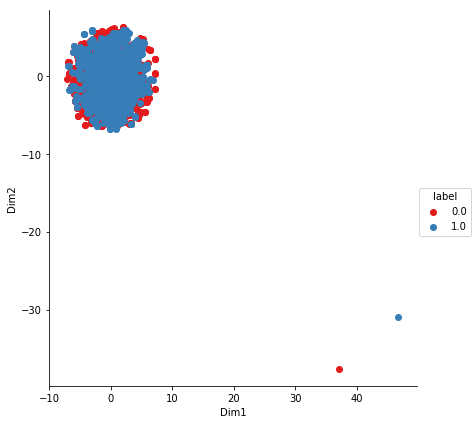

In [68]:
BOW_merge=np.vstack(( tsne_data.T, (score).T )).T

import seaborn as sn
tsne_df=pd.DataFrame(data=BOW_merge,columns=("Dim1","Dim2","label"))
sn.FacetGrid(tsne_df,hue="label",palette="Set1",size=6).map(plt.scatter,"Dim1","Dim2").add_legend()

Ran TSNE with 2000 datapoints each of positive and negative . So as we can see nothing can be distinguished using BOW methods 

In [18]:
#using TF-IDF method
with open('tfidf.pkl', 'rb') as f:
    final_tf_idf=pickle.load(f)

In [19]:
from sklearn.manifold import TSNE

#labels_1000=list(filtered_data["Score"]).T
model=TSNE(n_components=2,random_state=0,perplexity=100,n_iter=5000)
tsne_data=model.fit_transform((final_tf_idf).todense())


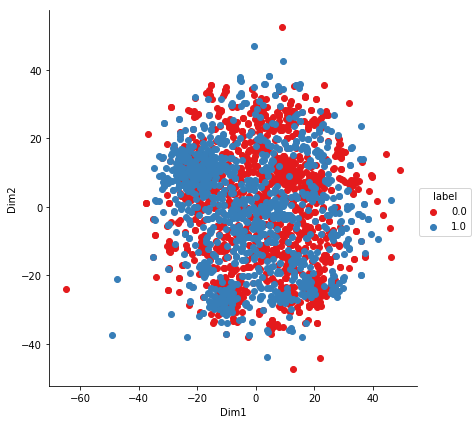

In [20]:
tfidf_merge=np.vstack(( tsne_data.T, (score).T )).T

import seaborn as sn
tsne_df=pd.DataFrame(data=tfidf_merge,columns=("Dim1","Dim2","label"))
sn.FacetGrid(tsne_df,hue="label",palette="Set1",size=6).map(plt.scatter,"Dim1","Dim2").add_legend()

Results are much btter than TSNE.Still not satisfactory

In [31]:
#AvgW2v
from sklearn.manifold import TSNE

#labels_1000=list(filtered_data["Score"]).T
model=TSNE(n_components=2,random_state=0,perplexity=100,n_iter=5000)
tsne_data=model.fit_transform((sent_vectors))


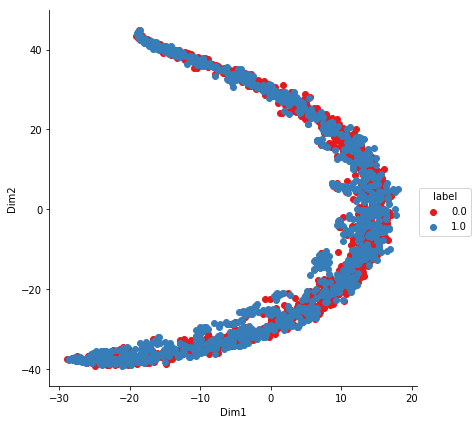

In [32]:
avgW2V_merge=np.vstack(( tsne_data.T, (score).T )).T

import seaborn as sn
tsne_df=pd.DataFrame(data=avgW2V_merge,columns=("Dim1","Dim2","label"))
sn.FacetGrid(tsne_df,hue="label",palette="Set1",size=6).map(plt.scatter,"Dim1","Dim2").add_legend()

No inference can be made


In [36]:
#weightedTF-IDF
#labels_1000=list(filtered_data["Score"]).T
model=TSNE(n_components=2,random_state=0,perplexity=100,n_iter=5000)
tsne_data=model.fit_transform((tfidf_sent_vectors))


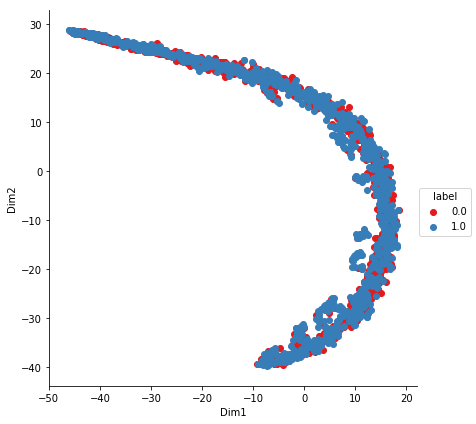

In [37]:
TFIDFWT_merge=np.vstack(( tsne_data.T, (score).T )).T

import seaborn as sn
tsne_df=pd.DataFrame(data=TFIDFWT_merge,columns=("Dim1","Dim2","label"))
sn.FacetGrid(tsne_df,hue="label",palette="Set1",size=6).map(plt.scatter,"Dim1","Dim2").add_legend()

Hence from the above figures we can infer that TSNE is unable to separate between positive and negative reviews.
Only 2000 datapoints have been taken
